In [1]:
import json
import os
import sys
import warnings
from glob import glob
from itertools import product
from pathlib import Path

warnings.filterwarnings('ignore')

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from tabulate import tabulate
from tqdm import tqdm

from src.metrics import calcul_average_rank, create_table
from src.utils import open_config
from src.datasets import make_dataset
from tools.attack import MODELS, test

In [2]:
length = 500
configs = list(map(open_config, glob(f'configs/*{length}.json')))
configs = sorted(configs, key=lambda x: x['model']['name'])

weights = sorted(list(filter(lambda x: str(length) in x, glob('models/*.pt'))))


In [3]:
train_dataset, test_dataset, train_sampler, val_sampler = make_dataset(configs[0], 'data/FordA/', return_loader=False)

In [4]:
len(test_dataset)

1320

In [10]:
ATTACK_PARMS_500 = {'bim': (0.02, 100),
                'deepfool': (0.5, 50),
                'simba': (2, 500)}

In [6]:
ATTACK_PARMS_150 = {'bim': (0.002, 200),
                'deepfool': (0.5, 50),
                'simba': (10, 1000)}

In [7]:
results = {}

In [11]:
for method in ATTACK_PARMS_500:
    method_params = ATTACK_PARMS_500[method]
    if method != 'simba': continue
    for config, weight in zip(configs, weights):
        m_name = config['model']['name']
        # if m_name != 'lstm':continue
        results.setdefault(method, {})
        
        iters, changed, pert_norms = test(config, weight, method, *method_params, scale=1)
        results[method][m_name] = {'iters': iters, 'pert_norms': pert_norms}
        print(np.nanmean(changed))
    joblib.dump(results, '500_results_fixed_seed_1.pkl')
    # break

100%|██████████| 1320/1320 [20:12<00:00,  1.09it/s]


0.8174242424242424


 46%|████▌     | 606/1320 [18:49<22:10,  1.86s/it]  


KeyboardInterrupt: 

In [8]:
from src.attacks.simba import simba
from src.datasets import make_dataset
import torch

In [9]:
config = configs[0]
weight = weights[0]
method = 'simba'
method_params = ATTACK_PARMS_150[method]

In [10]:
model = MODELS[config['model']['name']] # TODO move all such dicts to one place
model = model(config)

In [13]:
iters, changed, pert_norms = test(config, weight, method, *method_params, scale=0.001)

100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


In [12]:
np.nanmean(iters), np.nanmean(changed), np.nanmean(pert_norms)

(10.1, 0.6, 1.5885166764259337)

In [14]:
np.nanmean(iters), np.nanmean(changed), np.nanmean(pert_norms)

(10.1, 0.6, 1.5885166764259337)

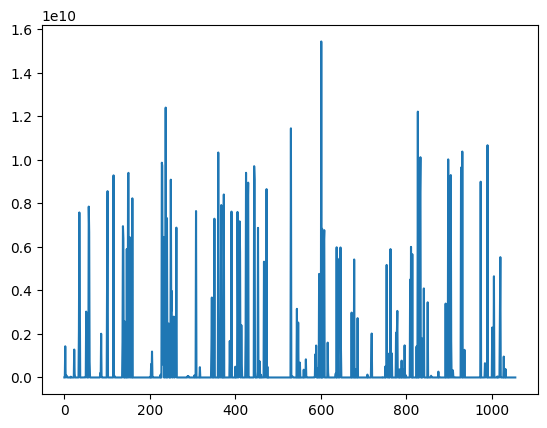

In [27]:
plt.plot(pert_norms)

In [10]:
funcs = [np.mean, np.median, np.std]
keys = ['pert_norms', 'iters']

In [16]:
ATTACK_PARMS_150

{'bim': (0.002, 200), 'deepfool': (1, 1000), 'simba': (30, 2500)}

In [22]:
results

{'deepfool': {'cnn': {'iters': array([5., 3., 5., ..., 1., 1., 1.]),
   'pert_norms': array([0.1141459 , 0.03903657, 0.21062154, ..., 0.08015618, 0.07395636,
          0.04853832])},
  'lstm': {'iters': array([999., 999., 999., ...,   1.,   1.,   1.]),
   'pert_norms': array([2.28558797e+09, 5.82804834e+03, 1.53902512e+06, ...,
          2.06020828e+02, 6.96678543e+00, 9.21430349e-01])},
  'transformer': {'iters': array([1., 2., 5., ..., 1., 1., 1.]),
   'pert_norms': array([0.01845479, 0.02016482, 0.02638147, ..., 0.05166331, 0.04945538,
          0.0503871 ])}},
 'simba': {'cnn': {'iters': array([2., 2., 1., ..., 1., 1., 1.]),
   'pert_norms': array([3.84078431, 3.81198239, 2.77156615, ..., 3.30636358, 2.64717555,
          2.01710534])},
  'lstm': {'iters': array([ 4.,  7., 10., ...,  1.,  3.,  4.]),
   'pert_norms': array([5.26639414, 5.88668108, 6.745749  , ..., 3.35662556, 2.59323359,
          3.79231453])},
  'transformer': {'iters': array([2., 3., 3., ..., 3., 4., 2.]),
   'pe

In [31]:
for method in ATTACK_PARMS_150:
    n_iters = ATTACK_PARMS_150[method][1] - 1
    for model in MODELS:
        good_idx = np.where(results[method][model]['iters'] != n_iters)
        results[method][model]['iters'] = results[method][model]['iters'][good_idx]
        results[method][model]['pert_norms'] = results[method][model]['pert_norms'][good_idx]

In [54]:
(results['deepfool']['lstm']['pert_norms']).mean()

6177494.76045003

In [33]:
for key, func in product(keys, funcs):
    print(key, str(func).split()[1])
    print(tabulate(create_table(results, key, func), headers='keys', tablefmt='psql'))


pert_norms mean


+----------+-----------------------+------------------------------------------+-----------------------+
|          | cnn                   | lstm                                     | transformer           |
|----------+-----------------------+------------------------------------------+-----------------------|
| deepfool | 0.1 95% CI [0.1, 0.1] | 6177494.8 95% CI [1812411.2, 18544719.8] | 0.0 95% CI [0.0, 0.0] |
| simba    | 3.1 95% CI [3.1, 3.1] | 3.8 95% CI [3.8, 3.9]                    | 4.6 95% CI [4.5, 4.6] |
| bim      | 0.1 95% CI [0.1, 0.1] | 0.1 95% CI [0.1, 0.1]                    | 0.0 95% CI [0.0, 0.0] |
+----------+-----------------------+------------------------------------------+-----------------------+
pert_norms median


KeyboardInterrupt: 

## Plot iter distribution

In [6]:
results = joblib.load('500_results.pkl')

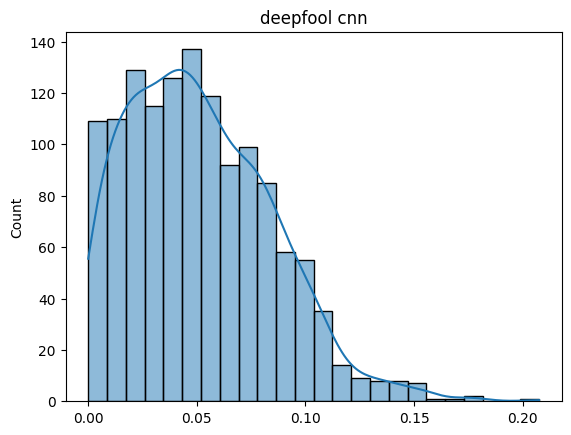

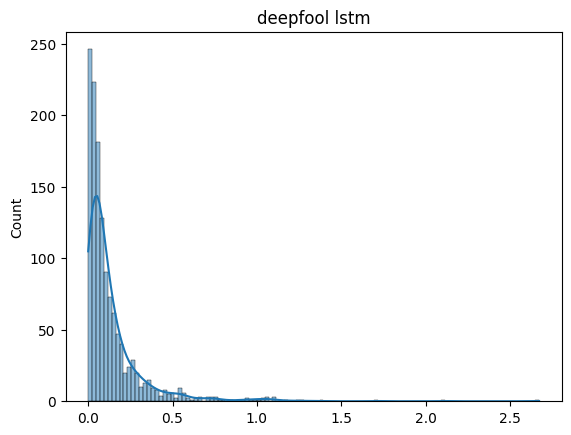

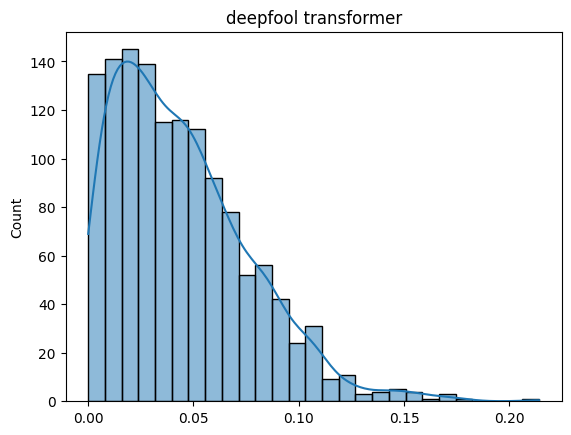

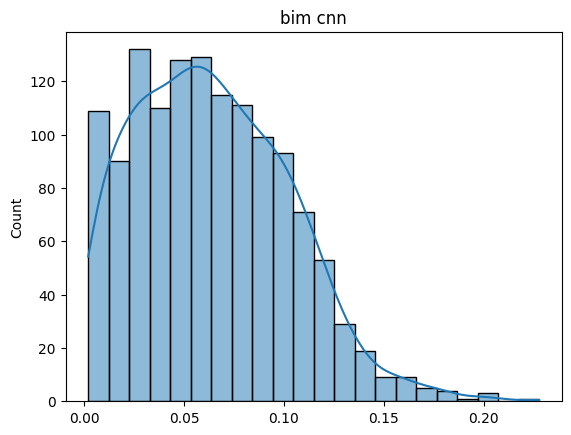

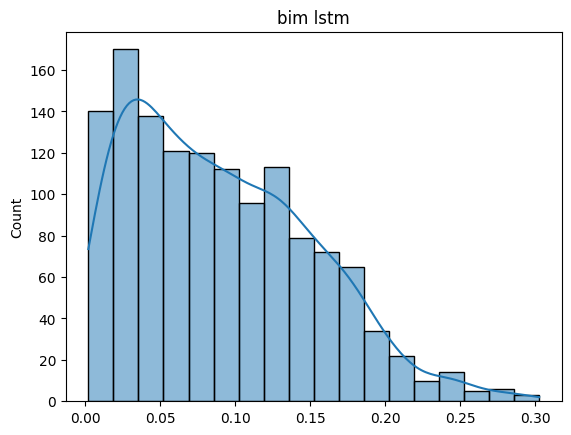

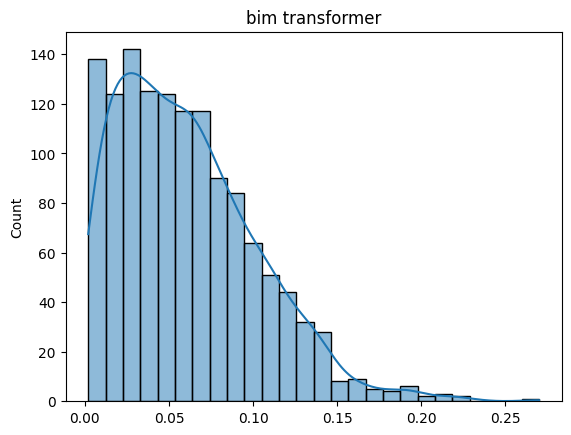

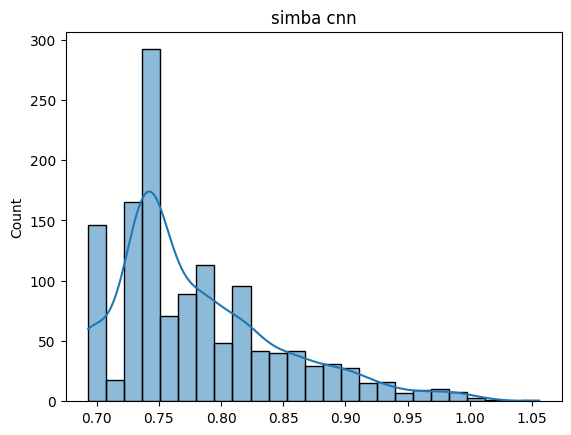

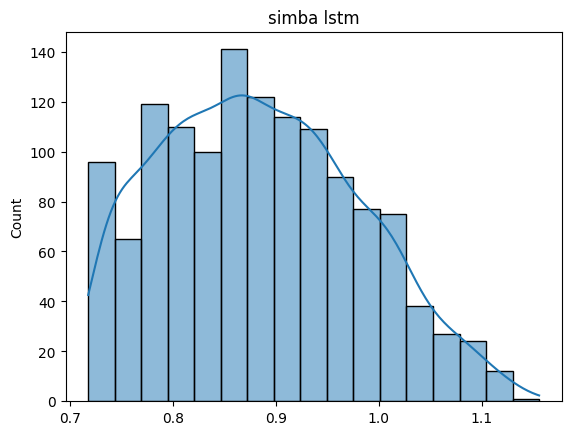

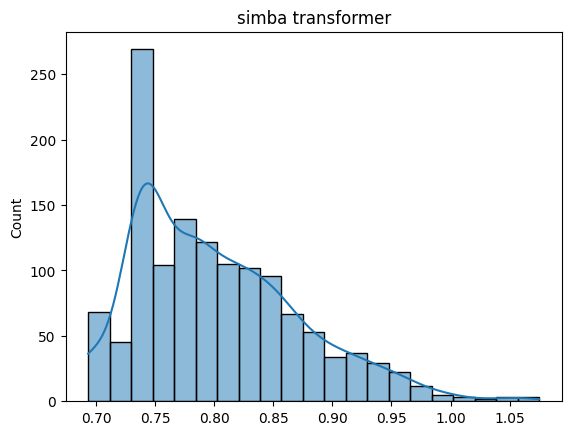

In [10]:
for method in results:
    for model in results[method]: #models
        arr = results[method][model]['pert_norms'] #array
        sns.histplot(data=np.log1p(arr), kde=True)
        plt.title(f'{method} {model}')
        plt.show()

## Average Rank

In [91]:
print(tabulate(calcul_average_rank(results), headers='keys', tablefmt='psql'))


+----------+--------------------------------------+--------------------------------------+--------------------------------------+
|          | cnn                                  | lstm                                 | transformer                          |
|----------+--------------------------------------+--------------------------------------+--------------------------------------|
| deepfool | 1.862879 95% CI [1.821212, 1.903788] | 2.446212 95% CI [2.403788, 2.487879] | 1.690909 95% CI [1.654545, 1.728223] |
| bim      | 1.840909 95% CI [1.798485, 1.884091] | 2.368182 95% CI [2.325000, 2.409848] | 1.790909 95% CI [1.751515, 1.831061] |
| simba    | 1.566667 95% CI [1.528788, 1.606818] | 2.596970 95% CI [2.559091, 2.630303] | 1.836364 95% CI [1.799242, 1.874242] |
+----------+--------------------------------------+--------------------------------------+--------------------------------------+


## Calcul parameters

In [105]:
cnn = MODELS[configs[1]['model']['name']](configs[1]) 
transformer = MODELS[configs[2]['model']['name']](configs[2]) 
lstm = MODELS[configs[0]['model']['name']](configs[0]) 

In [106]:
# Count the number of parameters in the transformer_encoder layer
transformer_encoder_params = sum(p.numel() for p in transformer.transformer_encoder.parameters())

# Count the number of parameters in the fc layer
fc_params = sum(p.numel() for p in transformer.fc.parameters())

print("Number of parameters in transformer_encoder:", transformer_encoder_params)
print("Number of parameters in fc layer:", fc_params)


Number of parameters in transformer_encoder: 214346
Number of parameters in fc layer: 1250302


In [107]:
# Count the number of parameters in the transformer_encoder layer
params = sum(p.numel() for p in lstm.lstm.parameters())

# Count the number of parameters in the fc layer
fc_params = sum(p.numel() for p in lstm.fc.parameters())

print("Number of parameters in lstm_layer:", params)
print("Number of parameters in fc layer:", fc_params)


Number of parameters in lstm_layer: 883200
Number of parameters in fc layer: 40602


In [108]:
# Count the number of parameters in the transformer_encoder layer
params = sum(p.numel() for p in cnn.backbone.parameters())

# Count the number of parameters in the fc layer
fc_params = sum(p.numel() for p in cnn.fc.parameters())

print("Number of parameters in cnn:", params)
print("Number of parameters in fc layer:", fc_params)


Number of parameters in cnn: 451242
Number of parameters in fc layer: 12384770


## Estimate with random seed

In [5]:
cnn_conf = configs[0]

In [6]:
cnn_conf

{'data': {'step': 50, 'batch_size': 64, 'seq_length': 500},
 'model': {'name': 'cnn', 'backbone': {'input_dim': 1, 'hidden_dim': 387}},
 'train': {'lr': 0.0005478412903817822,
  'n_epoch': 30,
  'optimizer': 'adam',
  'scheduler_config': {'type': None}},
 'random_state': 42}

In [7]:
weight

'rand_sweep_weights/cnn_34245.pt'

In [16]:
ATTACK_PARMS

{'bim': (0.002, 200), 'deepfool': (0.5, 50), 'simba': (10, 1000)}

In [8]:
data = []
for weight in tqdm(glob('rand_sweep_weights/cnn*.pt')):
    iters, changed, pert_norms = test(cnn_conf, weight, 'deepfool', *ATTACK_PARMS['deepfool'], verbose=False)
    data.append([iters, changed, pert_norms])
data = np.array(data)

 30%|██▉       | 118/397 [1:43:41<3:47:50, 49.00s/it]

In [ ]:
joblib.dump(data, 'cnn_random_deepfool.pkl')